In [1]:
# Importe
import pandas as pd
import numpy as np
import plotly.express as px
import matplotlib.pyplot as plt
from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import seaborn as sns

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LinearRegression
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

#import graphviz
from sklearn import tree
from matplotlib.dates import DateFormatter
import datetime as dt
from pandas import DataFrame
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

In [2]:
df = pd.read_csv('dataset_train.csv')

df['timestamp'] = pd.to_datetime(df['timestamp'])
#Aus Tabelle
err_1_start = dt.datetime(2022,2,28,21,53)
err_1_end = dt.datetime(2022,3,1,2,00)
err_2_start = dt.datetime(2022,3,23,14,54)
err_2_end = dt.datetime(2022,3,23,15,24)
err_3_start = dt.datetime(2022,5,30,12,00)
err_3_end = dt.datetime(2022,6,2,6,18)

df['Label'] = np.where(
    ((df['timestamp'] >= err_1_start) & (df['timestamp'] <= err_1_end)) |
    ((df['timestamp'] >= err_2_start) & (df['timestamp'] <= err_2_end)) | 
    ((df['timestamp'] >= err_3_start) & (df['timestamp'] <= err_3_end)), 1, 0)

In [ ]:
oil = df[['Oil_temperature', 'Label', 'timestamp']]

In [ ]:
t = np.linspace(0, 10, 1000)

def sin(t, A, F):
    return A * np.sin(2 * np.pi * F * t)

y = sin(t, 1, 1) + sin(t, 0.5, 2) + sin(t, 0.25, 4) + sin(t, 0.125, 8)

#plot with plotly
fig = px.line(x=t, y=y)
fig.show()

In [3]:
def yfft(y):
    hanning = np.hanning(len(y))
    yf = 4*np.abs(np.fft.rfft(y*hanning))/len(y)
    return yf

def xfft(blocksize, duration):
    return np.fft.rfftfreq(blocksize, duration)

In [ ]:
y_fft = yfft(y)
x_fft = xfft(len(t), t[1]-t[0])

px.bar(x=x_fft, y=y_fft)

In [ ]:
#blocksize
BLOCKSIZE = 1024
HIGHEST_FREQU = 1000

#number of blocks
nblocks = int(len(oil)/BLOCKSIZE)

data = []

#TODO:
#Notiz an mich:
#Prüfen in der Loop ob der zug ausgeschaltet wird, wenn ja block droppen!

X_f = xfft(BLOCKSIZE, 1)
X_f = X_f[X_f<HIGHEST_FREQU]
for i in range(nblocks):
    df_block = oil.iloc[i*BLOCKSIZE:(i+1)*BLOCKSIZE]


    iserr    = df_block['Label'].sum() > BLOCKSIZE/2
    fft_amp  = yfft(df_block['Oil_temperature'])[:len(X_f)]
    block_data = {'iserr': iserr}
    block_data.update({f'':amp for i,amp in enumerate(fft_amp)})
    data.append(block_data)

In [32]:
def fourier(blocksize, max_freq, series, name):

    #number of blocks
    nblocks = int(len(series)/blocksize)

    data = []

    X_f = xfft(blocksize, 1)
    X_f = X_f[X_f<max_freq]
    for i in range(nblocks):
        sr_block = series[i*blocksize:(i+1)*blocksize]
        # iserr    = df_block['Label'].sum() > BLOCKSIZE/2
        fft_amp  = yfft(sr_block)[:len(X_f)]
        # block_data = {'iserr': iserr}
        data.append({f'{name}_{j}':amp for j,amp in enumerate(fft_amp)})

    return pd.DataFrame(data)

def getError(blocksize, series, name):
    #number of blocks
    nblocks = int(len(series)/blocksize)

    data = []

    for i in range(nblocks):
        sr_block = series[i*blocksize:(i+1)*blocksize]

        iserr    = sr_block.sum() > blocksize/2
        # block_data = {'iserr': iserr}
        data.append({f'{name}':iserr})

    return pd.DataFrame(data)

def getMean(blocksize, series, name):
    #number of blocks
    nblocks = int(len(series)/blocksize)

    data = []

    for i in range(nblocks):
        sr_block = series[i*blocksize:(i+1)*blocksize]

        mean    = sr_block.mean()
        # block_data = {'iserr': iserr}
        data.append({f'{name}':mean})

    return pd.DataFrame(data)

def countPeaks(blocksize, series, name):
    #number of blocks
    nblocks = int(len(series)/blocksize)

    data = []

    for i in range(nblocks):
        sr_block = series[i*blocksize:(i+1)*blocksize]

        count    = sr_block[sr_block > 0.5].count()
        # block_data = {'iserr': iserr}
        data.append({f'{name}':count})

    return pd.DataFrame(data)

In [41]:
df_features = pd.DataFrame()

blocks = 700

tp3 = fourier(blocks,1000, df['TP3'], 'TP3')
oil = fourier(blocks, 1000, df['Oil_temperature'], 'Oil')
res = fourier(blocks, 1000, df['Reservoirs'], 'Res')
motCurr = fourier(blocks, 1000, df['Motor_current'], 'MotCurr')
h1 = fourier(blocks, 1000, df['H1'], 'H1')
LPS = getMean(blocks, df['LPS'], 'LPS')
DV_pressure_peaks = countPeaks(blocks, df['DV_pressure'], 'DV_pressure_peaks')

errors = getError(blocks, df['Label'], 'Error')

df_features = pd.concat([df_features, tp3, oil,errors, res, motCurr, h1, LPS, DV_pressure_peaks], axis=1)
df_features

,TP3_0,TP3_1,TP3_2,TP3_3,TP3_4,TP3_5,TP3_6,TP3_7,TP3_8,TP3_9,...,H1_343,H1_344,H1_345,H1_346,H1_347,H1_348,H1_349,H1_350,LPS,DV_pressure_peaks
0,18.791117,9.420686,0.042790,0.009417,0.004424,0.002503,0.001062,0.001054,0.000574,0.000476,...,0.000126,0.000131,0.000095,0.000080,0.000111,0.000149,0.000128,0.000199,0.0,0
1,16.961119,8.494522,0.116341,0.012472,0.021313,0.007657,0.004805,0.008747,0.009217,0.013566,...,0.000346,0.000170,0.000320,0.000272,0.000740,0.000422,0.000690,0.000272,0.0,0
2,18.986843,9.502735,0.024888,0.014374,0.015320,0.014420,0.012216,0.009198,0.005943,0.003045,...,0.000733,0.000725,0.000617,0.000670,0.000484,0.000668,0.000261,0.000756,0.0,2
3,17.390615,8.760463,0.106975,0.011308,0.032160,0.023864,0.013714,0.002447,0.008526,0.010652,...,0.000122,0.000126,0.000140,0.000115,0.000130,0.000225,0.000199,0.000105,0.0,0
4,19.402469,9.854810,0.152783,0.116113,0.079807,0.048059,0.028508,0.012257,0.008944,0.006183,...,0.011182,0.011069,0.011141,0.010871,0.011047,0.011124,0.011002,0.011114,0.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15385,17.279638,8.298925,0.645218,0.337393,0.174361,0.087449,0.035221,0.028781,0.038013,0.039936,...,0.016504,0.017593,0.017602,0.016579,0.015630,0.015930,0.017105,0.017716,0.0,0
15386,17.268179,8.653082,0.081150,0.019804,0.007695,0.004314,0.002499,0.001503,0.001185,0.000595,...,0.000589,0.000782,0.000610,0.000606,0.000644,0.000693,0.000651,0.000648,0.0,0
15387,18.524351,9.279373,0.084608,0.030273,0.017891,0.012533,0.009121,0.006698,0.005280,0.003527,...,0.000706,0.000733,0.000607,0.000616,0.000423,0.000786,0.000611,0.000529,0.0,0
15388,18.347631,9.541682,0.760843,0.367064,0.197847,0.087976,0.019082,0.021842,0.042970,0.047736,...,0.013536,0.010837,0.011824,0.015245,0.017086,0.015953,0.012757,0.010736,0.0,0


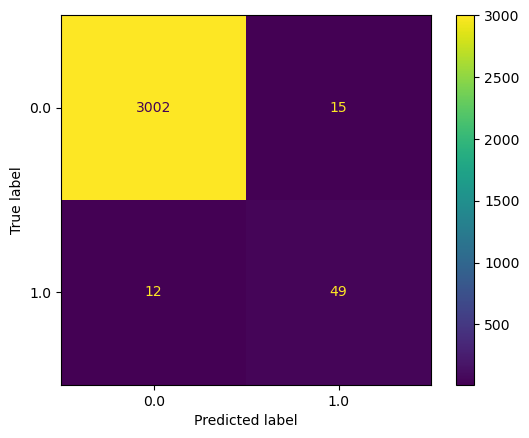

In [42]:
#decision tree
X = df_features.drop('Error', axis=1)
y = df_features['Error']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

clf = DecisionTreeClassifier()
clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)

cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=clf.classes_)
disp.plot()

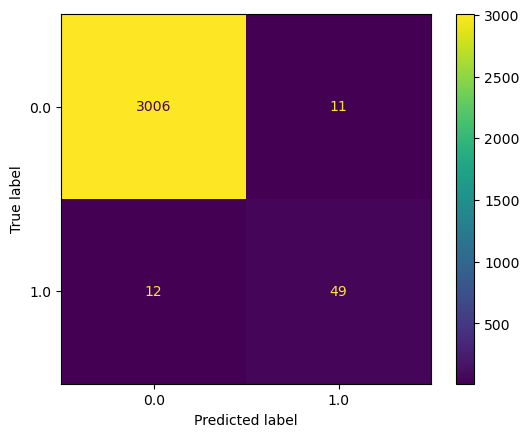

In [43]:
# WITH SCALE
copy = df_features.copy()
scaler = MinMaxScaler()
copy = pd.DataFrame(scaler.fit_transform(copy), columns=copy.columns)
#decision tree
X = copy.drop('Error', axis=1)
y = copy['Error']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

clf = DecisionTreeClassifier()
clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)

cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=clf.classes_)
disp.plot()

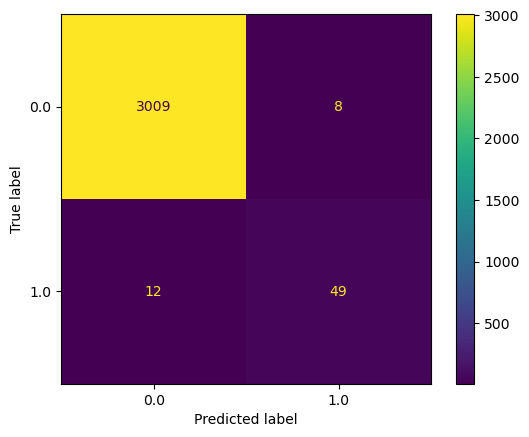

In [44]:
#random forest
clf = RandomForestClassifier()
clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=clf.classes_)
disp.plot()

In [37]:
x= list(df_features.columns.values)
x.remove('Error')

C:\Users\jhorst\AppData\Local\Temp\ipykernel_34760\1443700871.py:15: UserWarning:

Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.



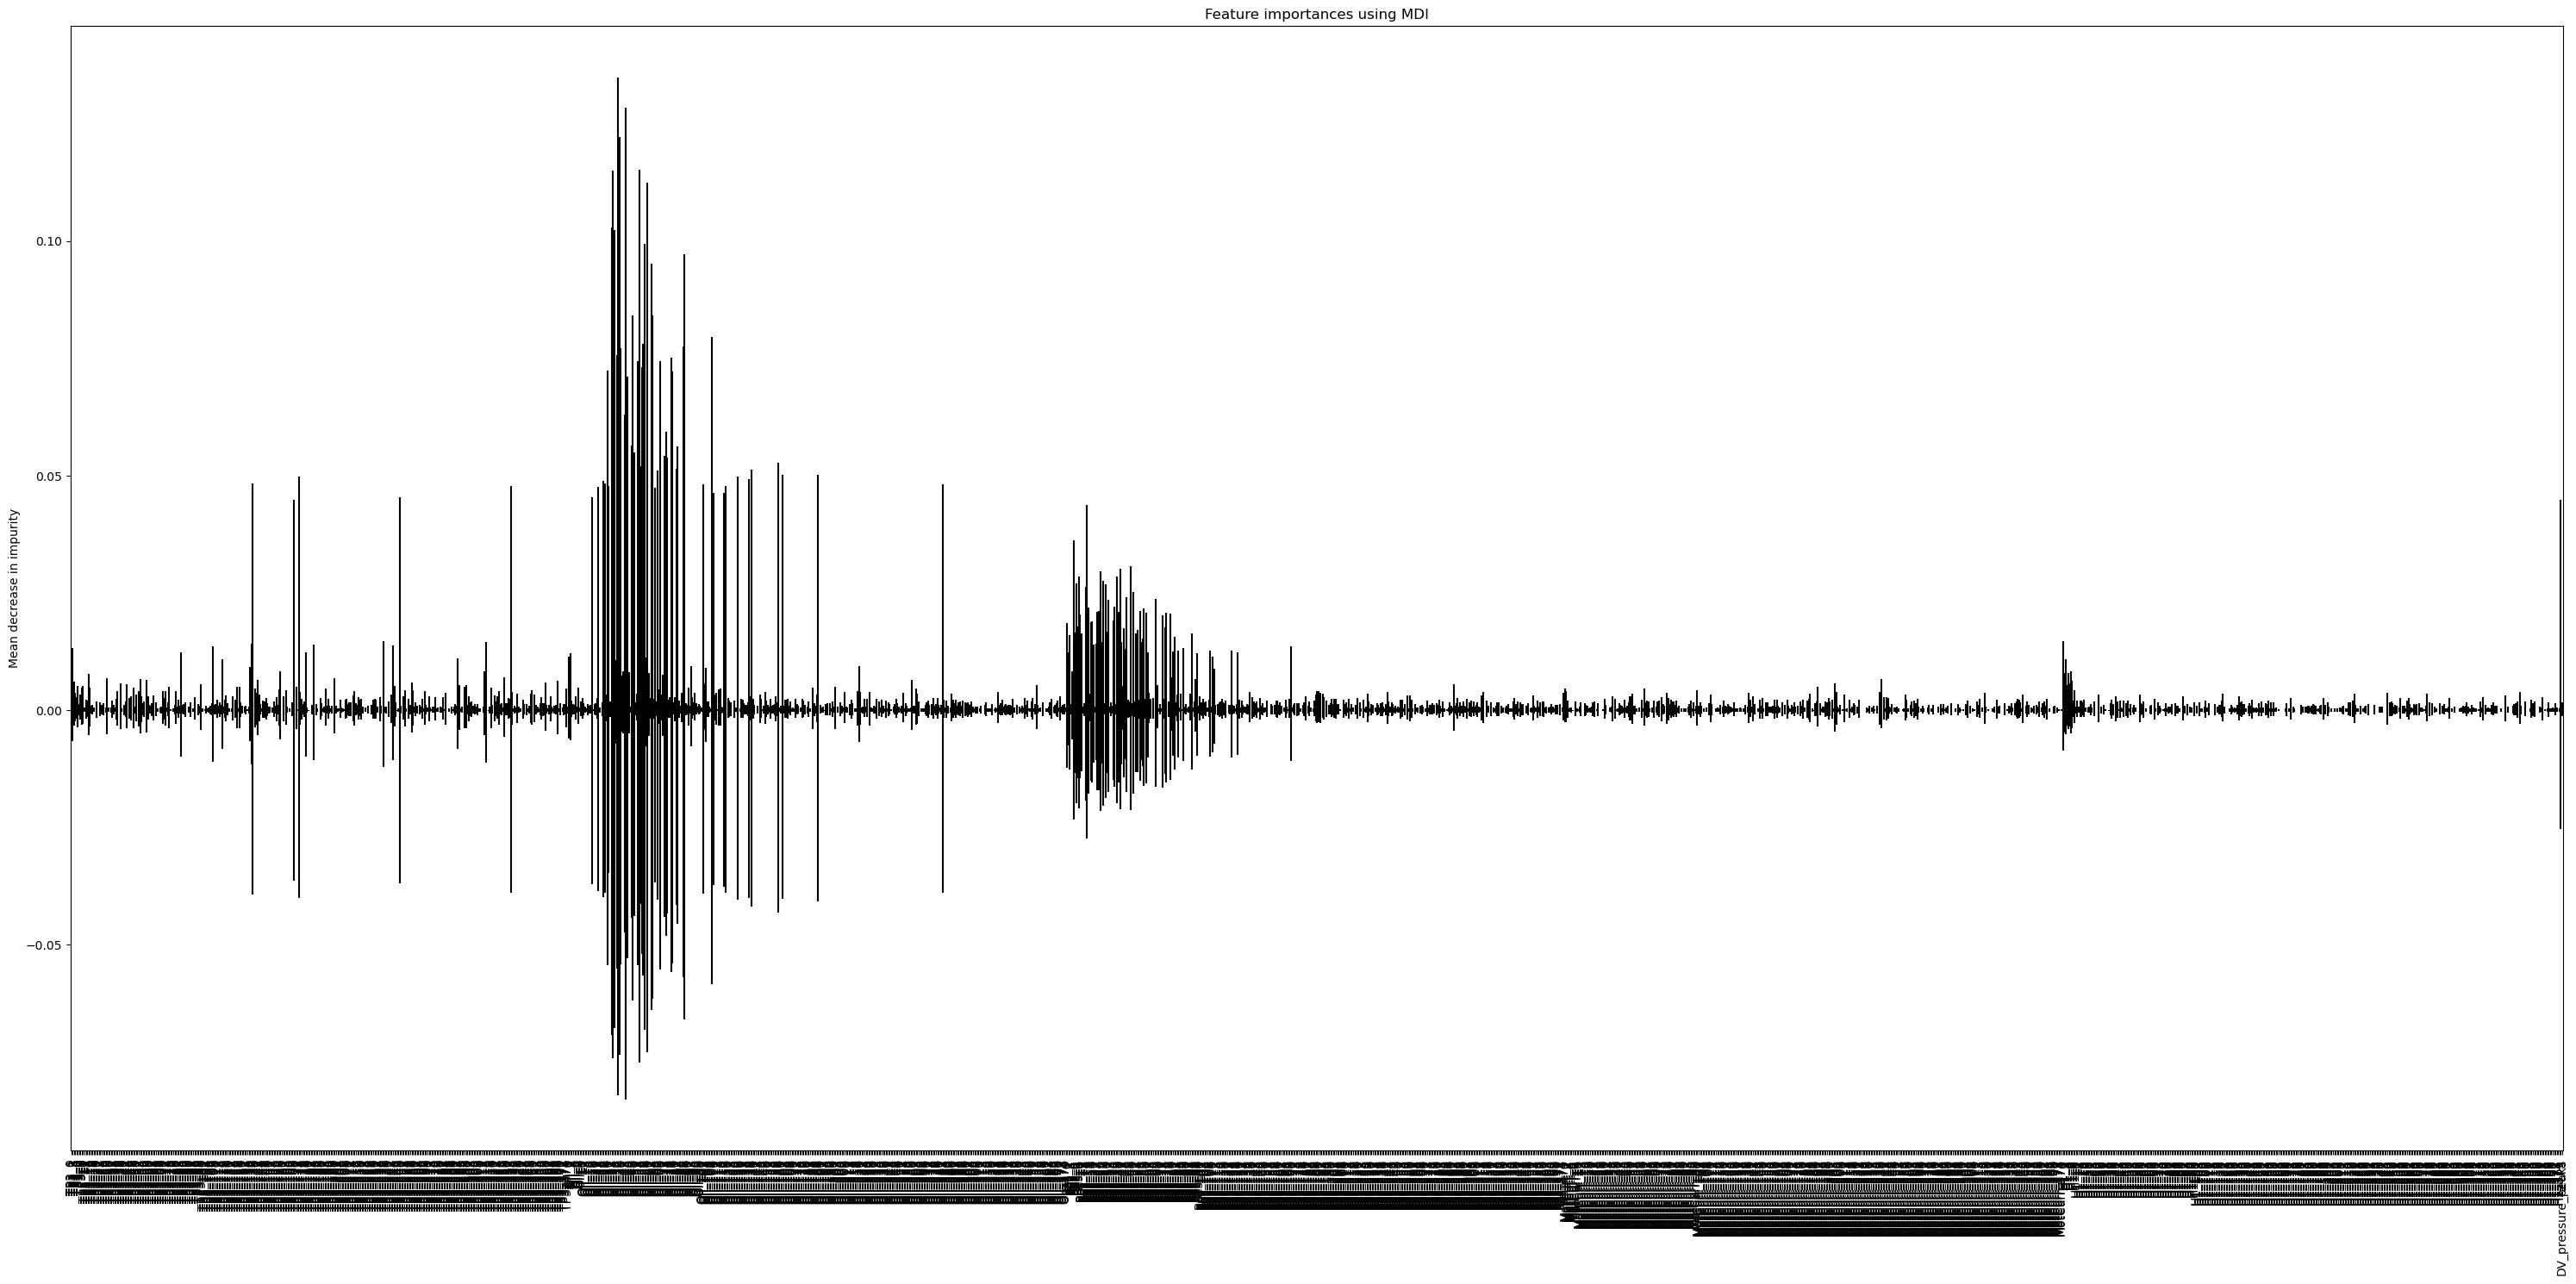

In [38]:
featureColls = list(df_features.columns.values)
featureColls.remove('Error')

importances = clf.feature_importances_
forest = clf
forest_importances = pd.Series(importances, index=featureColls)
std = np.std([tree.feature_importances_ for tree in forest.estimators_], axis=0)
fig, ax = plt.subplots()
forest_importances.plot.bar(yerr=std, ax=ax)
ax.set_title("Feature importances using MDI")
ax.set_ylabel("Mean decrease in impurity")
fig.set_figheight(15)
fig.set_figwidth(30)
fig.tight_layout()
fig.show()

In [39]:
1/xfft(1024, 1)[73]

14.027397260273972

In [40]:
px.bar(x=featureColls, y=forest_importances)

In [ ]:
oil['hasCut'] = oil['timestamp'].diff(1).dt.total_seconds() != 1

In [ ]:
oil

In [ ]:
oil_df = pd.DataFrame(data)

f_cols = [c for c in oil_df.columns if c != "iserr"]
scaler = MinMaxScaler()
# oil_df[f_cols] = scaler.fit_transform(oil_df[f_cols])
oil_df

In [ ]:
fig = px.imshow(oil_df[[c for c in oil_df.columns if not c in (["iserr"])]].T, height=700)
fig.add_scatter(y=oil_df["iserr"])
fig
#px.bar (x=xfft(BLOCKSIZE, 1), y=data[0])

In [ ]:
# #train test
# #df_train, df_test = train_test_split(oil_df, test_size=0.2,shuffle=False, stratify=oil_df['iserr'])
# df_train = oil_df.iloc[2800:10400] 
# df_train.loc[df_train.index < 6500, "iserr"] = False

# df_test = pd.concat([oil_df.iloc[:2800], oil_df.iloc[10400:]])

# y_train = df_train['iserr']
# y_test = df_test['iserr']


# X_train = df_train.drop(columns=['iserr'])
# X_test = df_test.drop(columns=['iserr'])

# #model
# model = DecisionTreeClassifier()
# model.fit(X_train, y_train)

# y_pred = model.predict(X_test)
# y_true = y_test

# #confusion matrix
# cm = confusion_matrix(y_true, y_pred)
# disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model.classes_)
# disp.plot()

In [ ]:
#train test
df_train, df_test = train_test_split(oil_df, test_size=0.2,shuffle=True, stratify=oil_df['iserr'])
y_train = df_train['iserr']
y_test = df_test['iserr']
#y_train = oil_df['iserr']


X_train = df_train.drop(columns=['iserr'])
#X_train = oil_df.drop(columns=['iserr'])
X_test = df_test.drop(columns=['iserr'])

#model
model = DecisionTreeClassifier()
model.fit(X_train, y_train)

In [ ]:
y_pred = model.predict(X_test)
y_true = y_test

#confusion matrix
cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model.classes_)
disp.plot()

In [ ]:
#transform false to 0 and true to 1
oil_df['iserr'] = oil_df['iserr'].astype(int)
y = y_test.astype(int)

y.plot()